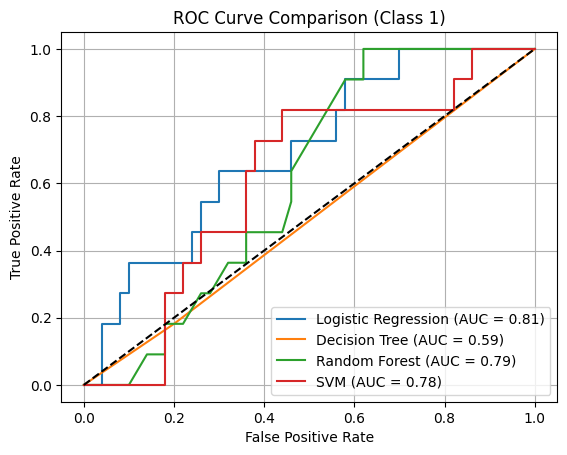


Model: Logistic Regression
Accuracy: 0.6393
Precision: 0.5553
Recall: 0.6393
F1-Score: 0.5917
ROC AUC: 0.8146

Model: Decision Tree
Accuracy: 0.4754
Precision: 0.4873
Recall: 0.4754
F1-Score: 0.4781
ROC AUC: 0.5897

Model: Random Forest
Accuracy: 0.5738
Precision: 0.5151
Recall: 0.5738
F1-Score: 0.5420
ROC AUC: 0.7873

Model: SVM
Accuracy: 0.5574
Precision: 0.4295
Recall: 0.5574
F1-Score: 0.4840
ROC AUC: 0.7802


In [2]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Load data and columns info
df = pd.read_csv('../data/heart_disease_clean.csv')
with open('../models/cols.json', 'r') as f:
    cols = json.load(f)
num_cols = cols['num_cols']
cat_cols = cols['cat_cols']

# 2. Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# 3. Train/test split (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Build preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# 5. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# 6. Train, predict, evaluate
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC AUC': auc}

    # Plot ROC Curve per model (One-vs-Rest)
    fpr = dict()
    tpr = dict()
    n_classes = y_prob.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr[1], tpr[1], label=f"{name} (AUC = {auc:.2f})")

# 7. Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Class 1)')
plt.legend()
plt.grid(True)
plt.show()

# 8. Print results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")
